In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import logging
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
from sklearn.model_selection import train_test_split
import joblib
import os
from sklearn.preprocessing import LabelEncoder 
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from joblib import Parallel, delayed



In [2]:
# Add KNN to the MODELS dictionary
MODELS = {
    #"MLP": (MLPClassifier(random_state=17, max_iter=1000, alpha=0.001), {  
    #    "hidden_layer_sizes": [(50, 50), (100, 50)],  
    #}),
    #"SVM": (SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, max_iter=1000, random_state=17, class_weight="balanced"), {}),  # Replaced LinearSVC with SGDClassifier
    # "KNN": (KNeighborsClassifier(n_jobs=-1), {
    #     "n_neighbors": [1, 3, 5],  
    #     "weights": ["uniform", "distance"]  
    # }),
    "XGB": (XGBClassifier(random_state=17, n_jobs=-1, verbosity=0, use_label_encoder=False), {}),
    #"NB": (GaussianNB(), {}),  
    #"LR": (LogisticRegression(random_state=17, n_jobs=-1, max_iter=5000, class_weight="balanced"), {}),  
    # "RF": (RandomForestClassifier(random_state=17, n_jobs=-1), {
    #     "n_estimators": [100, 200, 300],  
    #     "criterion": ["gini", "entropy"],
    #     "max_depth": [10, 20, None],  
    #     "min_samples_split": [2, 5],
    #     "max_features": ["sqrt"]
    # }),
    # "DT": (DecisionTreeClassifier(random_state=17, class_weight="balanced"), {
    #     "criterion": ["gini", "entropy"],
    #     "max_depth": [10, 20, None],  
    #     "min_samples_split": [2, 5]
    # })
}

In [3]:
def feature_importance_analysis(model, column_names):
    """Analyzes feature importance for the trained XGBoost model."""
    if isinstance(model, xgb.XGBClassifier):
        importance = model.feature_importances_
        sorted_idx = np.argsort(importance)[::-1]
        
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(sorted_idx[:20])), importance[sorted_idx[:20]], align='center')
        plt.xticks(range(len(sorted_idx[:20])), [column_names[i] for i in sorted_idx[:20]], rotation=90)
        plt.xlabel("Feature")
        plt.ylabel("Importance Score")
        plt.title("Top 20 Feature Importance in XGBoost")
        plt.show()
        
        logging.info("Top Features: ")
        for i in sorted_idx[:20]:
            logging.info(f"{column_names[i]}: {importance[i]:.4f}")
    else:
        logging.warning("Feature importance analysis is only supported for XGBoost models.")

In [4]:
def train_model(file_name, model_name, model, X_train, y_train, X_test, y_test, column_names):
    """Helper function to train and evaluate a single model."""
    base_name = file_name.replace(".parquet", "")
    model_filename = f"{base_name}_{model_name}.joblib"

    # Check if the model file already exists
    if os.path.exists(model_filename):
        logging.info(f"Model {model_name} already exists at {model_filename}. Loading and evaluating.")
        model = joblib.load(model_filename)
        feature_importance_analysis(model, column_names)
        accuracy = 0
        precision = 0
        recall = 0
        f1 = 0
        conf_matrix = 0
        return model, accuracy, precision, recall, f1, conf_matrix, 0.0  # No training time

In [5]:
def test_datasets(file_name, MODELS):
    """Tests the effectiveness of oversampling using various models and saves trained models."""
    logging.info(f"Testing oversampling for {file_name}")
    try:
        df = pd.read_parquet(file_name)
    except FileNotFoundError:
        logging.error(f"File not found: {file_name}")
        return
    except Exception as e:
        logging.error(f"Error reading file: {file_name} - {e}")
        return

    X = df.drop(columns=["Label"])
    column_names = X.columns  # Save column names
    encoder = LabelEncoder()
    y = encoder.fit_transform(df["Label"])

    # Split the dataset before scaling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Parallel execution of model training
    results = Parallel(n_jobs=1)(
        delayed(train_model)(file_name, model_name, model, X_train, y_train, X_test, y_test, column_names)
        for model_name, (model, _) in MODELS.items()
    )

2025-03-28 19:49:28,421 - INFO - Testing oversampling for final.parquet
2025-03-28 19:50:39,717 - INFO - Model XGB already exists at final_XGB.joblib. Loading and evaluating.
c:\Users\Daniel\anaconda3\envs\tf\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\data\../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


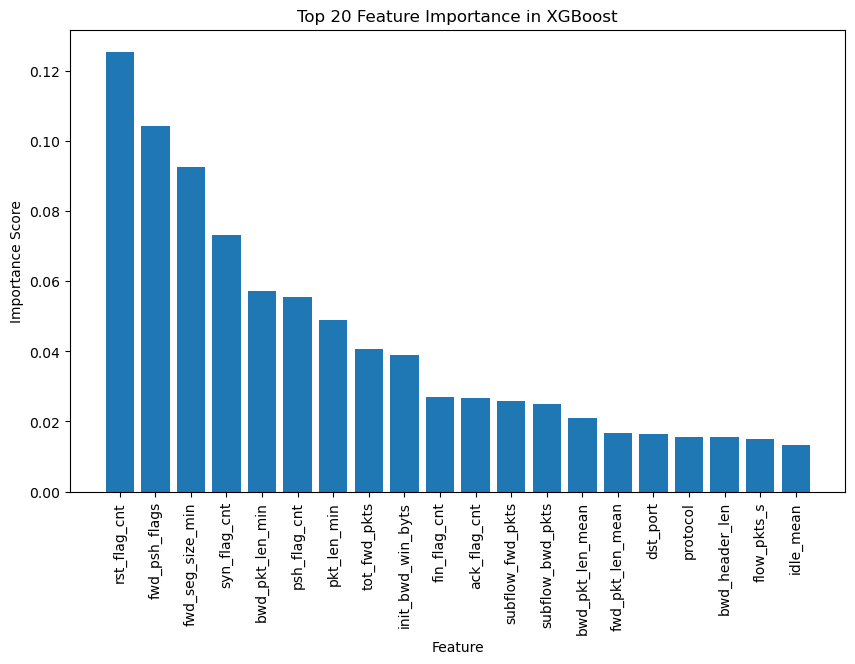

2025-03-28 19:50:41,521 - INFO - Top Features: 
2025-03-28 19:50:41,533 - INFO - rst_flag_cnt: 0.1254
2025-03-28 19:50:41,533 - INFO - fwd_psh_flags: 0.1042
2025-03-28 19:50:41,533 - INFO - fwd_seg_size_min: 0.0925
2025-03-28 19:50:41,540 - INFO - syn_flag_cnt: 0.0732
2025-03-28 19:50:41,540 - INFO - bwd_pkt_len_min: 0.0572
2025-03-28 19:50:41,540 - INFO - psh_flag_cnt: 0.0553
2025-03-28 19:50:41,540 - INFO - pkt_len_min: 0.0488
2025-03-28 19:50:41,540 - INFO - tot_fwd_pkts: 0.0406
2025-03-28 19:50:41,540 - INFO - init_bwd_win_byts: 0.0389
2025-03-28 19:50:41,540 - INFO - fin_flag_cnt: 0.0269
2025-03-28 19:50:41,540 - INFO - ack_flag_cnt: 0.0266
2025-03-28 19:50:41,540 - INFO - subflow_fwd_pkts: 0.0258
2025-03-28 19:50:41,540 - INFO - subflow_bwd_pkts: 0.0248
2025-03-28 19:50:41,540 - INFO - bwd_pkt_len_mean: 0.0211
2025-03-28 19:50:41,540 - INFO - fwd_pkt_len_mean: 0.0167
2025-03-28 19:50:41,540 - INFO - dst_port: 0.0165
2025-03-28 19:50:41,540 - INFO - protocol: 0.0156
2025-03-28 19:

In [6]:
test_datasets("final.parquet", MODELS)

In [3]:
import pandas as pd
import json

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Load your training data
df = pd.read_parquet('./Databases/final.parquet')

# 1. List all columns and their data types
print("Columns and Data Types:")
print(df.dtypes)

# 2. Check label distribution
print("\nLabel Distribution:")
print(df['Label'].value_counts())

# 3. Check feature statistics
print("\nFeature Statistics:")
print(df.describe())

# In your schema saving code:
schema = {
    'columns': list(df.columns),
    'dtypes': dict(df.dtypes.astype(str)),  # Convert dtype objects to strings
    'label_values': list(df['Label'].astype(str).unique())  # Ensure strings
}

with open('training_data_schema.json', 'w') as f:
    json.dump(schema, f, default=str, indent=2)  # Added default=str

Columns and Data Types:
bwd_pkt_len_max        int64
bwd_iat_min            int64
fwd_iat_max          float64
pkt_len_max            int64
subflow_fwd_byts       int64
fwd_pkt_len_min        int64
pkt_len_min            int64
down_up_ratio        float64
bwd_seg_size_avg     float64
flow_iat_mean        float64
active_min           float64
bwd_pkt_len_mean     float64
idle_min               int64
tot_fwd_pkts           int64
fwd_pkt_len_max        int64
rst_flag_cnt           int64
bwd_pkts_s           float64
bwd_iat_mean         float64
fwd_act_data_pkts      int64
pkt_len_var          float64
init_bwd_win_byts      int64
totlen_bwd_pkts        int64
idle_mean            float64
subflow_bwd_byts       int64
bwd_iat_std          float64
active_max           float64
subflow_bwd_pkts       int64
flow_byts_s          float64
fwd_pkt_len_std      float64
fwd_seg_size_avg     float64
fwd_iat_std          float64
bwd_pkt_len_std      float64
fwd_iat_mean         float64
bwd_iat_max        

In [ ]:
import json

# Load the updated training data schema
with open("training_data_schema.json", "r") as file:
    training_schema = json.load(file)

# Extract columns (features used for training) and total features
columns = set(training_schema.get("columns", []))  # Features you need
total_features = set(training_schema.get("total", []))  # All features

# Find features in total that are NOT in columns (these should be ignored)
features_to_ignore = total_features - columns

# Output the features to ignore
features_to_ignore

Features to ignore: {'BwdPacketsIATVariance', 'FwdSegmentSizeVariance', 'FwdPacketsDeltaTimeMin', 'ActiveMedian', 'IdleMode', 'FwdURGFlagPercentageInTotal', 'BwdPacketsIATStd', 'BwdPacketsIATMedian', 'FwdPacketsIATVariance', 'PacketsIATMean', 'FwdBytesRate', 'SubflowBwdPackets', 'FwdPacketsDeltaTimeMode', 'SYNFlagCounts', 'HeaderBytesDeltaLenMax', 'FwdPayloadBytesDeltaLenVariance', 'PayloadBytesMode', 'ACKFlagCounts', 'BwdPacketsIATCoV', 'BwdPayloadBytesVariance', 'FwdPayloadBytesSkewness', 'PacketsDeltaLenMode', 'BwdPayloadBytesMean', 'ActiveMax', 'BwdSkewnessHeaderBytes', 'FwdSYNFlagPercentageInTotal', 'DownUpRate', 'FwdSegmentSizeMin', 'BwdPacketsDeltaTimeStd', 'FwdPayloadBytesMedian', 'HeaderBytesDeltaLenSkewness', 'PacketsIATSkewness', 'FwdMeanHeaderBytes', 'BwdHeaderBytesDeltaLenMin', 'FwdPacketsCount', 'FwdMedianHeaderBytes', 'FwdHeaderBytesDeltaLenMax', 'BwdPacketsDeltaLenSkewness', 'BwdPSHFlagPercentageInBwdPackets', 'PacketsDeltaLenVariance', 'SYNFlagPercentageInTotal', 'Pack

In [ ]:
import pandas as pd

# Load your Excel file
df = pd.read_excel('Book1.xlsx')

# Mapping dictionary
column_mapping = {
    'bwd_payload_bytes_max': 'bwd_pkt_len_max',
    'bwd_packets_IAT_min': 'bwd_iat_min',
    'fwd_packets_IAT_max': 'fwd_iat_max',
    'payload_bytes_max': 'pkt_len_max',
    'subflow_fwd_bytes': 'subflow_fwd_byts',
    'fwd_payload_bytes_min': 'fwd_pkt_len_min',
    'payload_bytes_min': 'pkt_len_min',
    'down_up_rate': 'down_up_ratio',
    'bwd_segment_size_mean': 'bwd_seg_size_avg',
    'packets_IAT_mean': 'flow_iat_mean',
    'active_min': 'active_min',
    'bwd_payload_bytes_mean': 'bwd_pkt_len_mean',
    'idle_min': 'idle_min',
    'fwd_packets_count': 'tot_fwd_pkts',
    'fwd_payload_bytes_max': 'fwd_pkt_len_max',
    'rst_flag_count': 'rst_flag_cnt',
    'bwd_packets_rate': 'bwd_pkts_s',
    'bwd_packets_IAT_mean': 'bwd_iat_mean',
    'fwd_packets_count': 'fwd_act_data_pkts', #concern, still looking for feature equilavent
    'payload_bytes_variance': 'pkt_len_var',
    'bwd_init_win_bytes': 'init_bwd_win_byts',
    'bwd_total_payload_bytes': 'totlen_bwd_pkts',
    'idle_mean': 'idle_mean',
    'subflow_bwd_bytes': 'subflow_bwd_byts',
    'bwd_packets_IAT_std': 'bwd_iat_std',
    'active_max': 'active_max',
    'subflow_bwd_packets': 'subflow_bwd_pkts',
    'bytes_rate': 'flow_byts_s', #concern
    'fwd_payload_bytes_std': 'fwd_pkt_len_std',
    'fwd_segment_size_mean': 'fwd_seg_size_avg',
    'fwd_packets_IAT_std': 'fwd_iat_std',
    'bwd_payload_bytes_std': 'bwd_pkt_len_std',
    'fwd_packets_IAT_mean': 'fwd_iat_mean',
    'bwd_packets_IAT_max': 'bwd_iat_max',
    'fwd_segment_size_min': 'fwd_seg_size_min',
    'active_std': 'active_std',
    'payload_bytes_std': 'pkt_len_std',
    'syn_flag_counts': 'syn_flag_cnt',
    'fwd_total_payload_bytes': 'totlen_fwd_pkts',
    'fin_flag_counts': 'fin_flag_cnt',
    'bwd_total_header_bytes': 'bwd_header_len',
    'bwd_packets_count': 'tot_bwd_pkts',
    'fwd_packets_IAT_total': 'fwd_iat_tot',
    'urg_flag_counts': 'urg_flag_cnt',
    'psh_flag_counts': 'psh_flag_cnt',
    'fwd_packets_IAT_min': 'fwd_iat_min',
    'fwd_init_win_bytes': 'init_fwd_win_byts',
    'fwd_psh_flag_counts': 'fwd_psh_flags',
    'dst_port': 'dst_port',
    'fwd_total_header_bytes': 'fwd_header_len',
    'duration': 'flow_duration', # this is in .004293, etc. microseconds while flow_duration, originally is still microseconds but like 52340
    'payload_bytes_mean': 'pkt_size_avg',
    'packets_rate': 'flow_pkts_s', #concern
    'ack_flag_counts': 'ack_flag_cnt',
    'payload_bytes_mean': 'pkt_len_mean',
    'packet_IAT_min': 'flow_iat_min', #concern? Maybe packet by itself is flow?
    'packet_IAT_std': 'flow_iat_std',
    'subflow_fwd_packets': 'subflow_fwd_pkts',
    'bwd_payload_bytes_min': 'bwd_pkt_len_min',
    'active_mean': 'active_mean',
    'fwd_payload_bytes_mean': 'fwd_pkt_len_mean',
    'src_port': 'src_port',
    'packet_IAT_max': 'flow_iat_max', #concern?
    'protocol': 'protocol',
    'fwd_packets_rate': 'fwd_pkts_s',
    'bwd_packets_IAT_total': 'bwd_iat_tot',
    'idle_max': 'idle_max',
    'label': 'Label'
}

# Rename columns
df = df.rename(columns=column_mapping)
df.columns

Index(['flow_id', 'timestamp', 'src_ip', 'src_port', 'dst_ip', 'dst_port',
       'protocol', 'flow_duration', 'packets_count', 'fwd_act_data_pkts',
       ...
       'min_fwd_payload_bytes_delta_len', 'max_fwd_payload_bytes_delta_len',
       'mean_fwd_payload_bytes_delta_len', 'mode_fwd_payload_bytes_delta_len',
       'variance_fwd_payload_bytes_delta_len',
       'std_fwd_payload_bytes_delta_len', 'median_fwd_payload_bytes_delta_len',
       'skewness_fwd_payload_bytes_delta_len',
       'cov_fwd_payload_bytes_delta_len', 'Label'],
      dtype='object', length=347)

In [29]:
import os
import sys
import pandas as pd
import numpy as np
import warnings
import argparse
import logging
# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

warnings.filterwarnings('ignore')

## set port number as int
def portsAsInt(x):
    try:   #if is string
        if x.isnumeric():
            return int(x)    #if contains only decimals
        else:
            return int(x,16) #if contains hex number
    except:
        return np.NaN

## set protocol number as int by name
def protoNum(proto):
    trad = {"tcp":6, "udp":17, "ipv4":4, "icmp":1, "igmp":2, "ggp": 3, "ip": 0, "egp": 8, "pup": 12, "hmp": 20,
            "xns-idp": 22, "rdp": 27, "ipv6": 41, "ipv6-frag": 44, "ipv6-route": 43, "rvd": 66, "ipv6-opts": 60, "l2tp": 1701}
    if proto.isnumeric():
        return int(proto)
    if proto not in trad.keys():
        return np.NaN
    return trad[proto]


## returns flow ID string
def flowID(dataframe):
    return (dataframe['dst_ip'].apply(str) + '-' + dataframe['dst_port'].apply(str) + '-' + 
            dataframe['src_ip'].apply(str) + '-' + dataframe['src_port'].apply(str) + '-' + dataframe['protocol'].apply(str))

In [30]:
filepath = './Databases/1/'
pcapname = '1'
cicfm = pd.read_csv(filepath + "cic.csv", sep=',')

# Rename columns to match expected names
cicfm.rename(columns={
    'Src IP': 'src_ip',
    'Src Port': 'src_port',
    'Dst IP': 'dst_ip',
    'Dst Port': 'dst_port',
    'Protocol': 'protocol'
}, inplace=True)

cicfm['flow_ID'] = flowID(cicfm)

In [31]:
# nb15.pcap - NUSW-NB15_GT.csv (Source IP, Destination IP, Source Port, Destination Port, Protocol, Attack category)
# Use argus file to solve CICFlowMeter's protocol number issue
argus = pd.read_csv(filepath+"argus.csv", usecols=['SrcAddr','DstAddr','Sport','Dport','Proto'],
dtype={'SrcAddr':'string','DstAddr':'string'},
converters={'Proto':protoNum, 'Sport':portsAsInt ,'Dport':portsAsInt}, sep=',') # to fix protocol number in cic

argus.drop(argus[argus.isna().any(axis=1)].index, axis = 0, inplace = True)
argus.rename(columns={'SrcAddr':'src_ip','DstAddr':'dst_ip','Sport':'src_port','Dport':'dst_port','Proto':'protocol'}, 
    inplace=True)
argus = argus.astype({'src_port':'int32', 'dst_port':'int32','protocol':'int32'})

# Get right protocol number from argus file
cicfm.drop(['protocol'], axis = 1, inplace = True)
cicfm = cicfm.merge(argus,
    how='left',
    on=['src_ip', 'dst_ip', 'src_port', 'dst_port'])

cicfm.drop(cicfm[cicfm[['src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol']].isna().any(axis=1)].index, axis = 0, inplace = True)
cicfm.drop_duplicates(inplace=True)

In [32]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
cicfm.columns

Index(['Flow ID', 'src_ip', 'src_port', 'dst_ip', 'dst_port', 'Timestamp',
       'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s',
       'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len',
       'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min',
       'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var',
       'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt',
       'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt',
       '

In [33]:
cicfm.dtypes

Flow ID               object
src_ip                object
src_port               int64
dst_ip                object
dst_port               int64
Timestamp             object
Flow Duration          int64
Tot Fwd Pkts           int64
Tot Bwd Pkts           int64
TotLen Fwd Pkts      float64
TotLen Bwd Pkts      float64
Fwd Pkt Len Max      float64
Fwd Pkt Len Min      float64
Fwd Pkt Len Mean     float64
Fwd Pkt Len Std      float64
Bwd Pkt Len Max      float64
Bwd Pkt Len Min      float64
Bwd Pkt Len Mean     float64
Bwd Pkt Len Std      float64
Flow Byts/s          float64
Flow Pkts/s          float64
Flow IAT Mean        float64
Flow IAT Std         float64
Flow IAT Max         float64
Flow IAT Min         float64
Fwd IAT Tot          float64
Fwd IAT Mean         float64
Fwd IAT Std          float64
Fwd IAT Max          float64
Fwd IAT Min          float64
Bwd IAT Tot          float64
Bwd IAT Mean         float64
Bwd IAT Std          float64
Bwd IAT Max          float64
Bwd IAT Min   

In [34]:
cicfm.protocol

0      6.0
1      6.0
3      6.0
4      6.0
6      6.0
7      6.0
8      6.0
9      6.0
11     6.0
13     6.0
15     6.0
17     6.0
19     6.0
20     6.0
23     6.0
24     6.0
25     6.0
26     6.0
27     6.0
28     6.0
29     6.0
30     6.0
31     6.0
32     6.0
33     6.0
34     6.0
35     6.0
36     6.0
38     6.0
39    17.0
40     6.0
41     6.0
42     6.0
43     6.0
48     6.0
49     6.0
50     6.0
51     6.0
53     6.0
54     6.0
55     6.0
56     6.0
57     6.0
58     6.0
59     6.0
60     6.0
61     6.0
Name: protocol, dtype: float64

In [35]:
output = "processed_" + pcapname

# All still not set are Benign
cicfm.fillna(value={'Label': 'BENIGN'}, inplace=True)

#--------------#
# SAVE DATASET #
#--------------#

cicfm.to_csv("./Databases/" + pcapname + '/' + output + '_CIC.csv', index=None, header=True)

In [ ]:
import json
with open('training.json', 'r') as file: 
    data = json.load(file)
    for column in data['dtypes']: 
        print(column)

bwd_pkt_len_max
bwd_iat_min
fwd_iat_max
pkt_len_max
subflow_fwd_byts
fwd_pkt_len_min
pkt_len_min
down_up_ratio
bwd_seg_size_avg
flow_iat_mean
active_min
bwd_pkt_len_mean
idle_min
tot_fwd_pkts
fwd_pkt_len_max
rst_flag_cnt
bwd_pkts_s
bwd_iat_mean
fwd_act_data_pkts
pkt_len_var
init_bwd_win_byts
totlen_bwd_pkts
idle_mean
subflow_bwd_byts
bwd_iat_std
active_max
subflow_bwd_pkts
flow_byts_s
fwd_pkt_len_std
fwd_seg_size_avg
fwd_iat_std
bwd_pkt_len_std
fwd_iat_mean
bwd_iat_max
fwd_seg_size_min
active_std
pkt_len_std
syn_flag_cnt
totlen_fwd_pkts
fin_flag_cnt
bwd_header_len
tot_bwd_pkts
fwd_iat_tot
urg_flag_cnt
psh_flag_cnt
fwd_iat_min
init_fwd_win_byts
fwd_psh_flags
dst_port
fwd_header_len
flow_duration
pkt_size_avg
flow_pkts_s
ack_flag_cnt
pkt_len_mean
flow_iat_min
flow_iat_std
subflow_fwd_pkts
bwd_pkt_len_min
active_mean
fwd_pkt_len_mean
src_port
flow_iat_max
idle_std
protocol
fwd_pkts_s
bwd_iat_tot
idle_max
Label
